# Continual Unlearning Results Visualization

This notebook analyzes and visualizes the performance of different continual unlearning methods. We'll load results from JSON files stored in the checkpoints directory and compare various methods against the ground truth (retrain_continual_unlearn).

In [16]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [24]:
df = pd.read_csv('eval_results_for_cifar10.csv')
df = df[df['method'] != 'boundary_expanding']

In [25]:
# Function to calculate more precise accuracy metrics
def calculate_accurate_metrics(row):
    forget_class_end = int(row['forget_class_end'])
    
    # Get accuracy of the end forget class
    end_class_accuracy = row[f'train_accuracy_class_{forget_class_end}']
    
    # Calculate retained accuracy (classes after forget_class_end)
    retained_classes = [f'train_accuracy_class_{i}' for i in range(forget_class_end + 1, 10)]
    retain_accuracy = np.mean([row[col] for col in retained_classes]) if retained_classes else np.nan
    
    # Calculate remembered accuracy (classes before forget_class_end)
    remembered_classes = [f'train_accuracy_class_{i}' for i in range(0, forget_class_end)]
    remember_accuracy = np.mean([row[col] for col in remembered_classes]) if remembered_classes else np.nan

    end_class_accuracy_test = row[f'test_accuracy_class_{forget_class_end}']
    retain_accuracy_test = np.mean([row[f'test_accuracy_class_{i}'] for i in range(forget_class_end + 1, 10)]) if retained_classes else np.nan
    remember_accuracy_test = np.mean([row[f'test_accuracy_class_{i}'] for i in range(0, forget_class_end)]) if remembered_classes else np.nan
    
    return pd.Series({
        'end_class_accuracy': end_class_accuracy,
        'precise_retain_accuracy': retain_accuracy,
        'precise_remember_accuracy': remember_accuracy,
        'end_class_accuracy_test': end_class_accuracy_test,
        'precise_retain_accuracy_test': retain_accuracy_test,
        'precise_remember_accuracy_test': remember_accuracy_test
    })

# Apply the function to calculate the new metrics
additional_metrics = df.apply(calculate_accurate_metrics, axis=1)
df = pd.concat([df, additional_metrics], axis=1)

# Display the dataframe with new metrics
df[['method', 'forget_class_begin', 'forget_class_end', 'end_class_accuracy', 
    'precise_retain_accuracy', 'precise_remember_accuracy']].head(10)

,method,forget_class_begin,forget_class_end,end_class_accuracy,precise_retain_accuracy,precise_remember_accuracy
0,FT,0,0,1.866667,97.933334,NaN
1,FT,0,1,14.844444,98.416667,0.000000
2,FT,0,2,2.288889,97.996826,0.000000
3,FT,0,3,10.200000,99.577778,0.014815
4,FT,0,4,27.777779,99.506665,0.588889
5,FT,0,5,0.000000,99.916666,2.635555
6,FT,0,6,0.000000,99.807406,0.000000
7,FT,0,7,0.000000,99.877777,0.000000
8,synaptag_GA,0,0,0.000000,94.251852,NaN
9,synaptag_GA,0,1,0.000000,90.736111,0.000000


In [26]:
# Let's compare the reported metrics vs the precise calculated metrics
comparison_df = df[['method', 'forget_class_end', 'accuracy_retain', 'precise_retain_accuracy', 
                     'accuracy_forget', 'end_class_accuracy']].copy()

# Calculate difference between reported and calculated metrics
comparison_df['retain_diff'] = comparison_df['accuracy_retain'] - comparison_df['precise_retain_accuracy']
comparison_df['forget_diff'] = comparison_df['accuracy_forget'] - comparison_df['end_class_accuracy']

print("Average difference in retain accuracy:", comparison_df['retain_diff'].mean())
print("Average difference in forget accuracy:", comparison_df['forget_diff'].mean())

# Display comparison table
comparison_df.head(10)

Average difference in retain accuracy: 0.0049533866758870405
Average difference in forget accuracy: -0.014285722664749504


,method,forget_class_end,accuracy_retain,precise_retain_accuracy,accuracy_forget,end_class_accuracy,retain_diff,forget_diff
0,FT,0,98.012346,97.933334,1.844444,1.866667,0.079011,-0.022222
1,FT,1,98.694444,98.416667,14.933333,14.844444,0.277777,0.088889
2,FT,2,98.304762,97.996826,2.044444,2.288889,0.307936,-0.244444
3,FT,3,99.785185,99.577778,10.155556,10.200000,0.207407,-0.044444
4,FT,4,99.657778,99.506665,27.600000,27.777779,0.151113,-0.177779
5,FT,5,99.983333,99.916666,0.000000,0.000000,0.066667,0.000000
6,FT,6,99.896296,99.807406,0.000000,0.000000,0.088890,0.000000
7,FT,7,99.955556,99.877777,0.000000,0.000000,0.077778,0.000000
8,synaptag_GA,0,93.770370,94.251852,0.000000,0.000000,-0.481482,0.000000
9,synaptag_GA,1,90.600000,90.736111,0.000000,0.000000,-0.136111,0.000000


<Figure size 1600x1000 with 0 Axes>

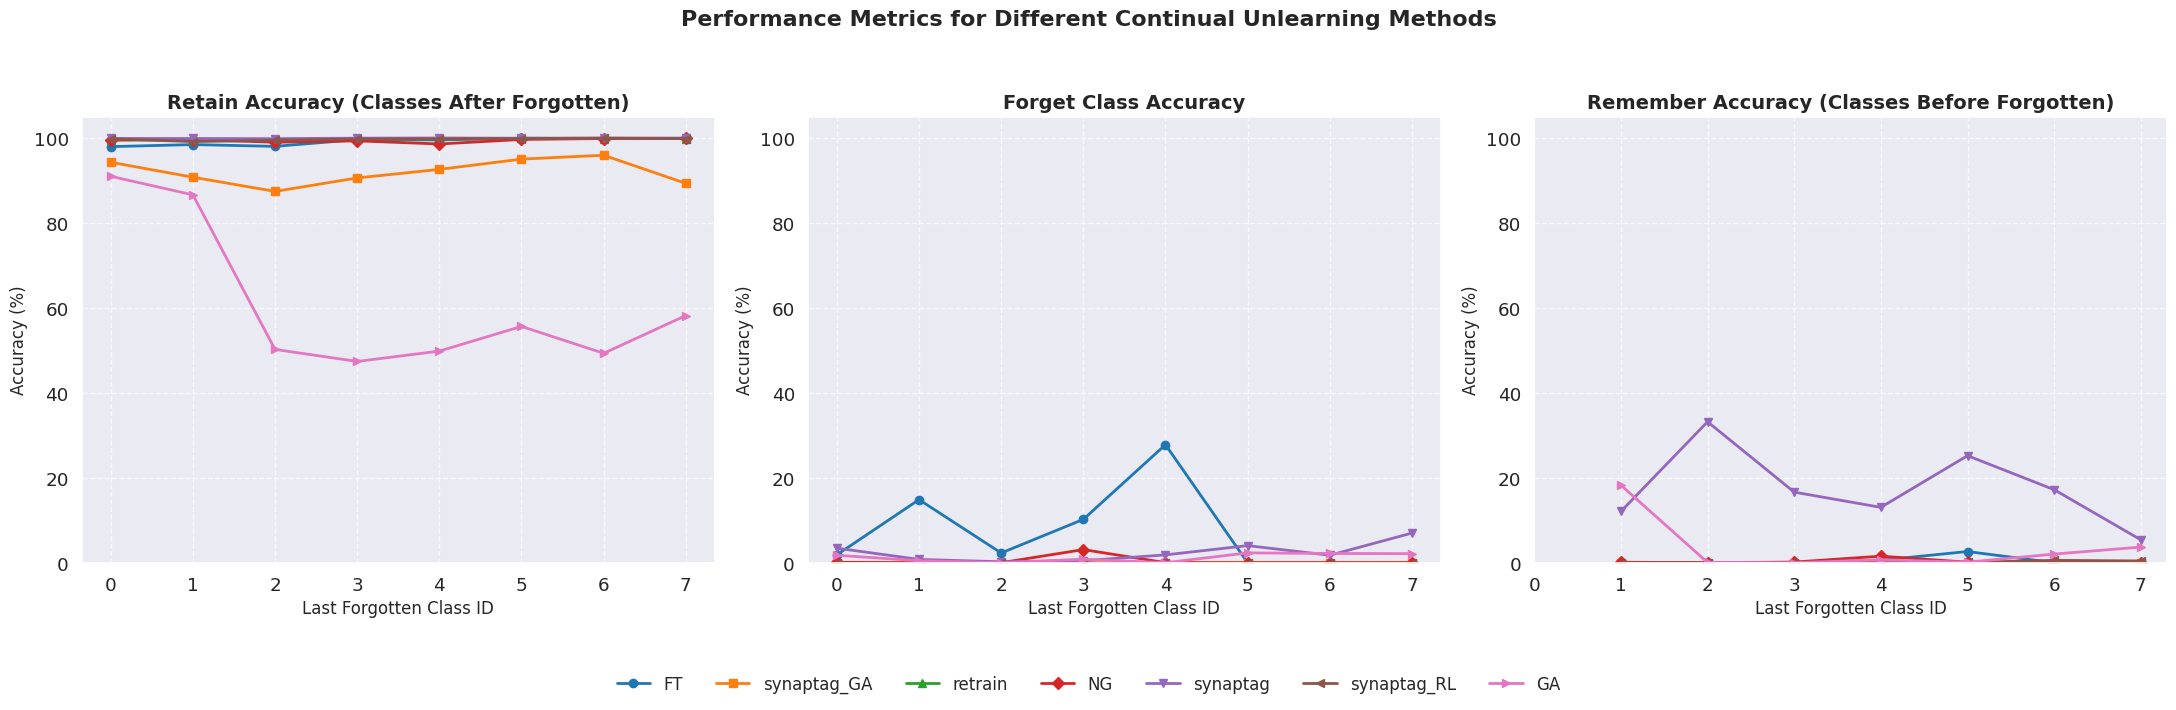

In [27]:
# Visualize the precise metrics for different methods as classes are forgotten
plt.figure(figsize=(16, 10))

# Get unique methods
methods = df['method'].unique()
colors = sns.color_palette("tab10", len(methods))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

for i, method in enumerate(methods):
    method_data = df[df['method'] == method].sort_values('forget_class_end')
    
    # Plot retain accuracy
    axs[0].plot(method_data['forget_class_end'], method_data['precise_retain_accuracy'], 
                marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    # Plot forget class accuracy
    axs[1].plot(method_data['forget_class_end'], method_data['end_class_accuracy'], 
                marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    # Plot remember accuracy
    axs[2].plot(method_data['forget_class_end'], method_data['precise_remember_accuracy'], 
                marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)

# Configure plots
titles = ['Retain Accuracy (Classes After Forgotten)', 'Forget Class Accuracy', 'Remember Accuracy (Classes Before Forgotten)']
ylabels = ['Accuracy (%)', 'Accuracy (%)', 'Accuracy (%)']

for i in range(3):
    axs[i].set_title(titles[i], fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Last Forgotten Class ID', fontsize=12)
    axs[i].set_ylabel(ylabels[i], fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.7)
    axs[i].set_ylim(0, 105)  # Set y-axis range from 0 to 105
    axs[i].set_xticks(range(0, 8))

# Add legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
          fancybox=True, shadow=True, ncol=len(methods), fontsize=12)

plt.suptitle('Performance Metrics for Different Continual Unlearning Methods', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

<Figure size 1600x1000 with 0 Axes>

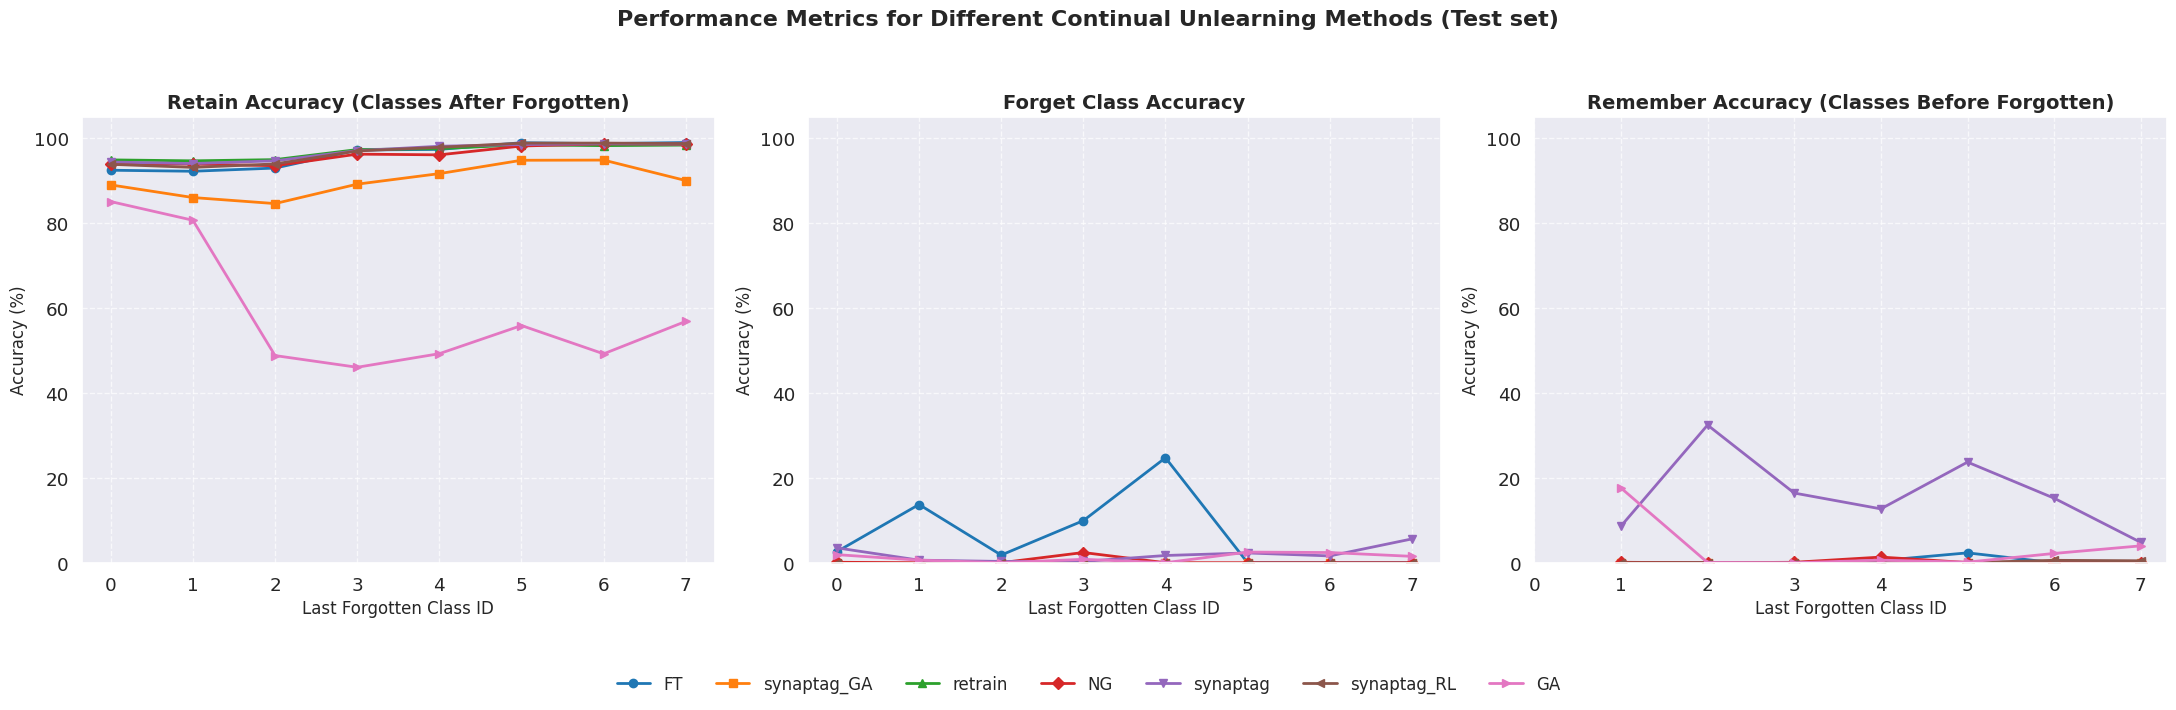

In [28]:
# Visualize the precise metrics for different methods as classes are forgotten
plt.figure(figsize=(16, 10))

# Get unique methods
methods = df['method'].unique()
colors = sns.color_palette("tab10", len(methods))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

for i, method in enumerate(methods):
    method_data = df[df['method'] == method].sort_values('forget_class_end')
    
    # Plot retain accuracy
    axs[0].plot(method_data['forget_class_end'], method_data['precise_retain_accuracy_test'], 
                marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    # Plot forget class accuracy
    axs[1].plot(method_data['forget_class_end'], method_data['end_class_accuracy_test'], 
                marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    # Plot remember accuracy
    axs[2].plot(method_data['forget_class_end'], method_data['precise_remember_accuracy_test'], 
                marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)

# Configure plots
titles = ['Retain Accuracy (Classes After Forgotten)', 'Forget Class Accuracy', 'Remember Accuracy (Classes Before Forgotten)']
ylabels = ['Accuracy (%)', 'Accuracy (%)', 'Accuracy (%)']

for i in range(3):
    axs[i].set_title(titles[i], fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Last Forgotten Class ID', fontsize=12)
    axs[i].set_ylabel(ylabels[i], fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.7)
    axs[i].set_ylim(0, 105)  # Set y-axis range from 0 to 105
    axs[i].set_xticks(range(0, 8))

# Add legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
          fancybox=True, shadow=True, ncol=len(methods), fontsize=12)

plt.suptitle('Performance Metrics for Different Continual Unlearning Methods (Test set)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

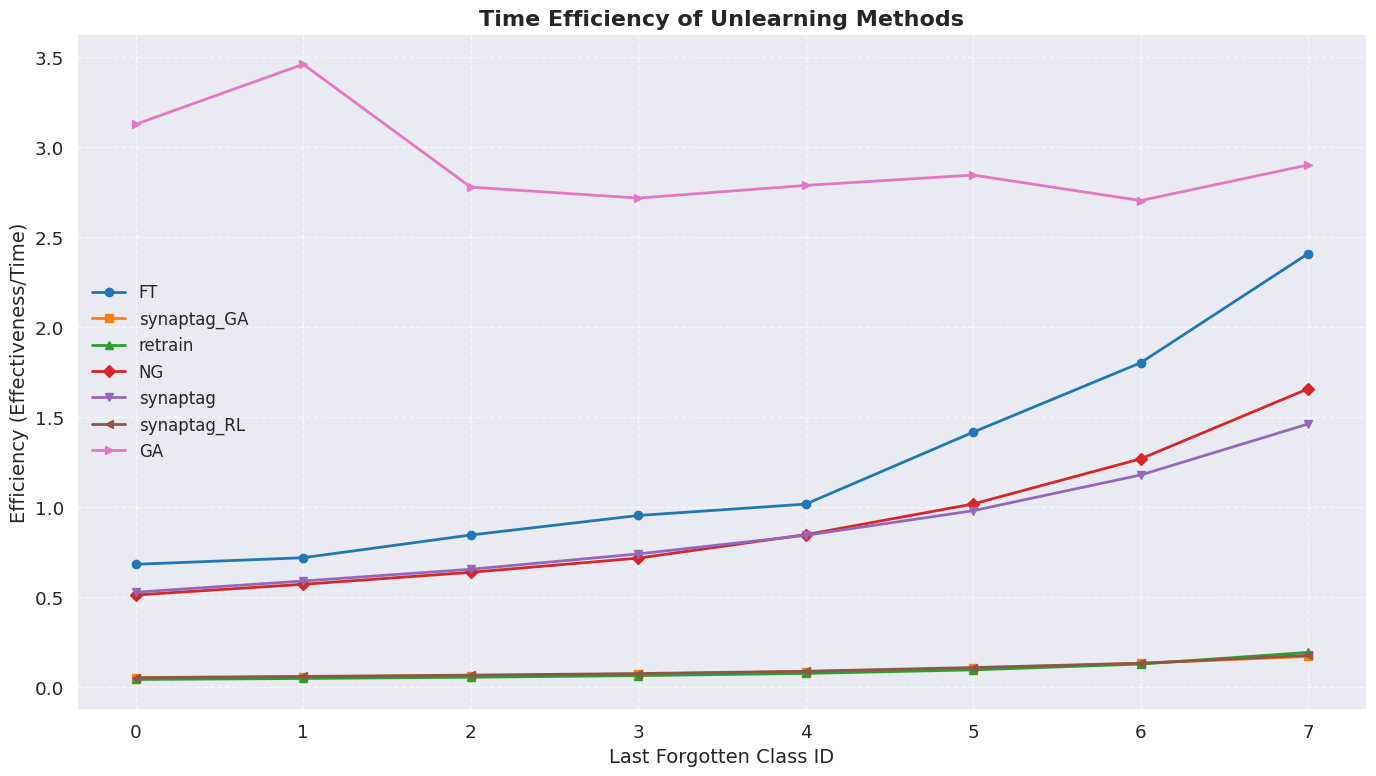

In [21]:
# Compute efficiency metrics: unlearning time vs performance
def calculate_efficiency(row):
    # Lower forget accuracy and higher retain accuracy is better
    forget_effectiveness = 100 - row['end_class_accuracy']  # Convert to "forgetfulness"
    retain_effectiveness = row['precise_retain_accuracy']
    
    # Overall effectiveness as a weighted combination
    overall_effectiveness = (forget_effectiveness + retain_effectiveness) / 2
    
    # Efficiency = effectiveness / time
    efficiency = overall_effectiveness / (row['unlearning_time'] + 1e-10)  # Avoid division by zero
    
    return pd.Series({
        'forget_effectiveness': forget_effectiveness,
        'retain_effectiveness': retain_effectiveness,
        'overall_effectiveness': overall_effectiveness,
        'time_efficiency': efficiency
    })

# Apply efficiency calculation
efficiency_metrics = df.apply(calculate_efficiency, axis=1)
df = pd.concat([df, efficiency_metrics], axis=1)

# Plot efficiency metric for each method as classes are forgotten
plt.figure(figsize=(14, 8))

for i, method in enumerate(methods):
    method_data = df[df['method'] == method].sort_values('forget_class_end')
    plt.plot(method_data['forget_class_end'], method_data['time_efficiency'],
             marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)

plt.title('Time Efficiency of Unlearning Methods', fontsize=16, fontweight='bold')
plt.xlabel('Last Forgotten Class ID', fontsize=14)
plt.ylabel('Efficiency (Effectiveness/Time)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(range(0, 8))
plt.tight_layout()
plt.show()

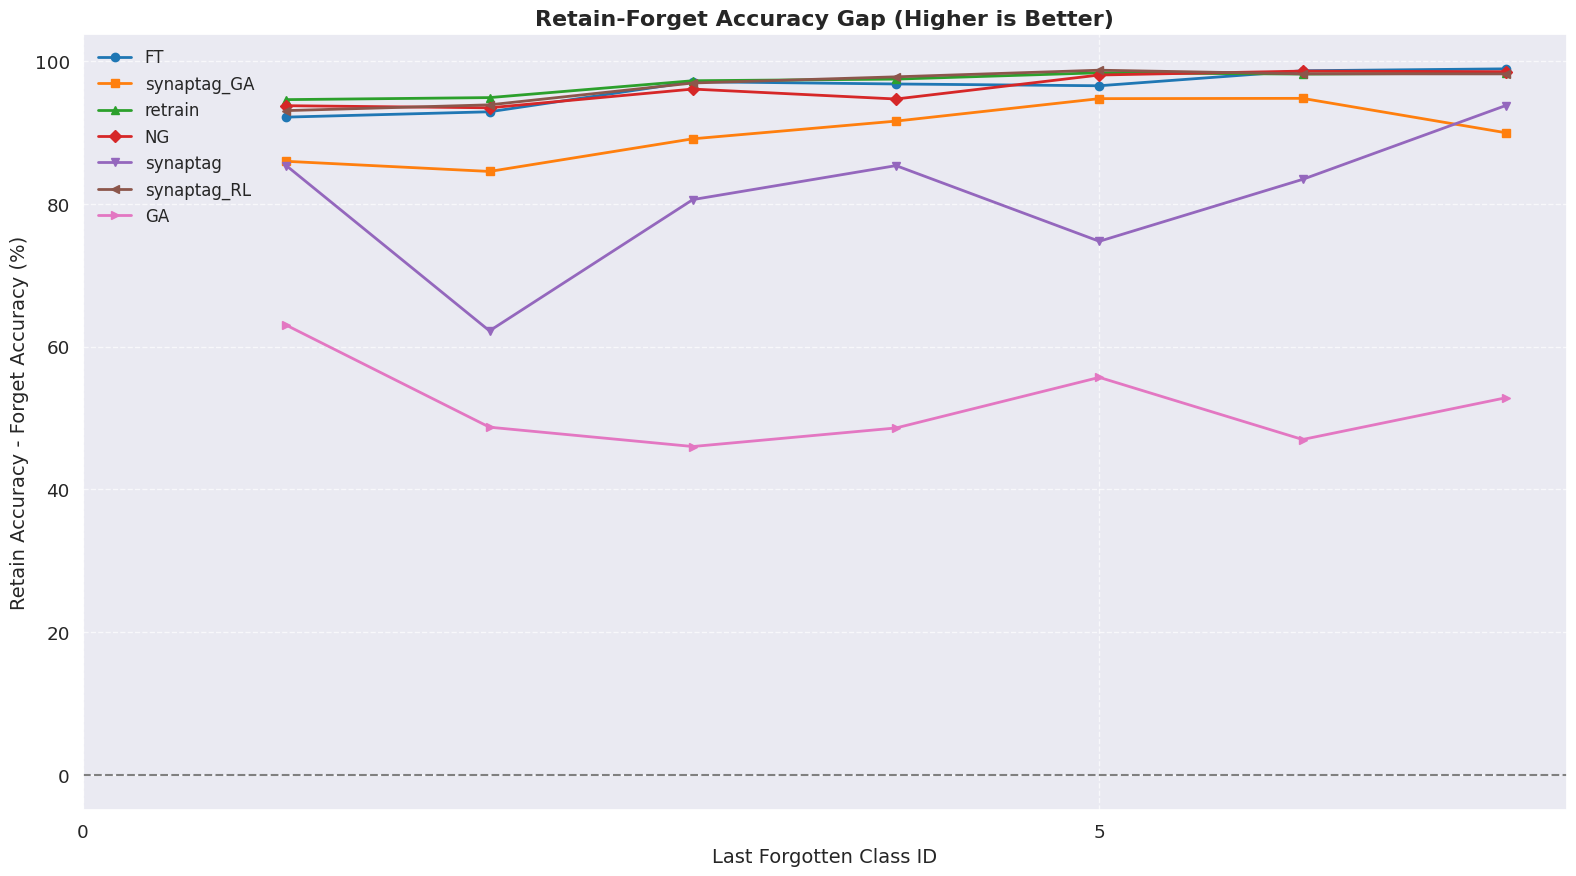

In [14]:
# Calculate and plot the Retain-Forget difference
if all(col in df.columns for col in ['end_class_accuracy', 'precise_retain_accuracy']):
    # Calculate the difference between retain accuracy and forget accuracy
    df['retain_forget_diff'] = df['precise_retain_accuracy'] - df['precise_remember_accuracy']
    
    # Get unique methods
    methods = df['method'].unique()
    colors = sns.color_palette("tab10", len(methods))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
    
    # Create plot - higher values are better (high retain, low forget)
    plt.figure(figsize=(16, 9))
    
    for i, method in enumerate(methods):
        method_data = df[df['method'] == method].sort_values('forget_class_end')
        if len(method_data) == 0:
            continue
            
        plt.plot(method_data['forget_class_end'], method_data['retain_forget_diff'],
                 marker=markers[i % len(markers)], label=method, color=colors[i], linewidth=2)
    
    plt.title('Retain-Forget Accuracy Gap (Higher is Better)', fontsize=16, fontweight='bold')
    plt.xlabel('Last Forgotten Class ID', fontsize=14)
    plt.ylabel('Retain Accuracy - Forget Accuracy (%)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Add a horizontal line at y=0 as a reference
    plt.axhline(y=0, color='grey', linestyle='--')
    
    # Dynamically set xticks based on data
    if 'forget_class_end' in df.columns:
        unique_classes = sorted(df['forget_class_end'].unique())
        if len(unique_classes) > 1:
            plt.xticks(unique_classes[::5])  # Show every 5th tick to avoid overcrowding
            
    plt.tight_layout()
    plt.show()